In [3]:
%matplotlib inline
import io
import time
import numpy as np
from PIL import Image
import picamera
import pandas as pd

In [13]:
stream = io.BytesIO()
with picamera.PiCamera() as picam:
    picam.start_preview()
    picam.vflip = False
    time.sleep(2)
    picam.capture(stream, format='bmp')
    picam.stop_preview()
    picam.close()
stream.seek(0)
image = Image.open(stream)
# stream.close()

In [14]:
# resize
image = image.resize((int(720/8), int(480/8)), Image.ANTIALIAS)

In [15]:
image.size

(90, 60)

In [33]:
from azure.cosmosdb.table.tableservice import TableService
from azure.storage.blob import BlockBlobService
from azure.cosmosdb.table.models import Entity
from azure.storage.file import ContentSettings
import sys
from time import time
import json
from io import BytesIO

In [29]:
with open('api_key.json', 'r') as f:
    app_key = json.loads(f.read())
block_blob_service = BlockBlobService(connection_string=app_key['azure_storage_connection'])

In [42]:
imagefile = BytesIO()
image.save(imagefile, format='PNG')
# imagedata = imagefile.getvalue()
imagefile.seek(0)
block_blob_service.create_blob_from_stream('nuknuk', 'test.bmp', imagefile)

### data format
- data[width][height]

In [23]:
im_data = np.asarray(image)
print(len(im_data))

60


In [20]:
crop_image = im_data[:45]
im = Image.fromarray(crop_image)

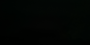

In [24]:
im

In [13]:
type(im)

PIL.Image.Image

In [52]:
#preview image
#image

In [25]:
# 데이터를 하나의 배열로 정리
image_dataset = []
for row in im_data:
    for item in row:
        image_dataset.append(item)
image_dataset = np.array(image_dataset)

In [26]:
df = pd.DataFrame(image_dataset, columns=['red','green','blue'])

In [27]:
df.head()

,red,green,blue
0,1,3,1
1,1,3,2
2,1,3,2
3,1,3,2
4,1,3,2


In [40]:
def is_night(df):
    if (np.mean(df.red) < 10.0 and
        np.mean(df.blue) < 10.0 and
        np.mean(df.green) < 10.0):
        return True
    return False

In [44]:
is_night(df)

True

In [15]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot  as plt

# create model and prediction
model = DBSCAN(eps=5, min_samples=10)
predict = pd.DataFrame(model.fit_predict(df))
predict.columns = ['predict']

# concatenate labels to df as a new column
r = pd.concat([df,predict],axis=1)

In [16]:
r.head()

,red,green,blue,predict
0,146,143,143,0
1,149,145,145,0
2,151,146,147,0
3,154,149,150,0
4,156,151,152,0


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=40, azim=135)
ax.scatter(r['red'],r['green'],r['blue'],c=r['predict'],alpha=0.5)
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')
plt.show()

In [18]:
for num in set([i for i in r['predict']]):
    print('{0}:{1}'.format(num, len([i for i in r['predict'] if i == num])))

0:5365
-1:35


In [45]:
# create dummy image
dummy = []

for i in range(10):
    inner_dummy = []
    for i in range(10):
        inner_dummy.append([i*20,255,i*20])
    dummy.append(np.array(inner_dummy, np.uint8))
    
dummy_im = Image.fromarray(np.array(dummy, np.uint8))

In [46]:
dummy_im

In [2]:
import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()

labels = pd.DataFrame(iris.target)
labels.columns=['labels']
data = pd.DataFrame(iris.data)
data.columns=['Sepal length','Sepal width','Petal length','Petal width']
data = pd.concat([data,labels],axis=1)

data.head()

,Sepal length,Sepal width,Petal length,Petal width,labels
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
feature = data[ ['Sepal length','Sepal width','Petal length','Petal width']]
feature.head()

,Sepal length,Sepal width,Petal length,Petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot  as plt
import seaborn as sns

# create model and prediction
model = DBSCAN(min_samples=6)
predict = pd.DataFrame(model.fit_predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Sepal length'],r['Sepal width'],r['Petal length'],c=r['predict'],alpha=0.5)
ax.set_xlabel('Sepal lenth')
ax.set_ylabel('Sepal width')
ax.set_zlabel('Petal length')
plt.show()